## VaR for the Normal distribution

To get accustomed to the Value at Risk (VaR) measure, it helps to apply it to a known distribution. The Normal (or Gaussian) distribution is especially appealing as it 1) has an analytically simple form, and 2) represents a wide variety of empirical phenomena. For now we'll assume that the loss of a portfolio is normally distributed, i.e., the higher the value drawn from the distribution, the higher the loss.

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

95% VaR:  1.6448536269514722 ; 99% VaR:  2.3221649634376265


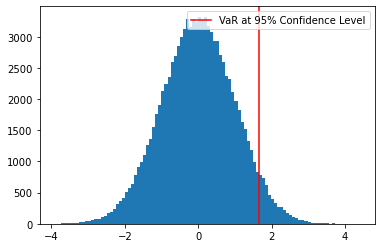

In [2]:
# Create the VaR measure at the 95% confidence level using norm.ppf()
VaR_95 = norm.ppf(0.95)

# Create the VaR meaasure at the 5% significance level using numpy.quantile()
draws = norm.rvs(size = 100000)
VaR_99 = np.quantile(draws, 0.99)

# Compare the 95% and 99% VaR
print("95% VaR: ", VaR_95, "; 99% VaR: ", VaR_99)

# Plot the normal distribution histogram and 95% VaR measure
plt.hist(draws, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.legend(); plt.show()

As the plot shows, the 95% VaR is about 1.65, which is the maximum loss that is expected to occur 95% of the time. We've also used both the inverse cumulative density function (the percent point function) and the quantile function to find the VaR

## Comparing CVaR and VaR

The conditional value at risk (CVaR), or expected shortfall (ES), asks what the average loss will be, conditional upon losses exceeding some threshold at a certain confidence level. It uses VaR as a point of departure, but contains more information because it takes into consideration the tail of the loss distribution.

In [3]:
import warnings
warnings.filterwarnings('ignore')

from pandas_datareader import DataReader
from datetime import datetime

stocklist = ['C', 'MS', 'GS', 'JPM']

start = datetime(2004,12,31)
end = datetime(2010,12,31)

portfolio = DataReader(stocklist, 'yahoo',start, end)['Close']
portfolio.rename(columns={'C':'Citibank', 'MS':'Morgan Stanley','GS':'Goldman Sachs','JPM':'J.P. Morgan'}, inplace=True)
portfolio.head()

weights = [0.25, 0.25, 0.25, 0.25]

In [4]:
# Compute the portfolio's daily returns
portfolio_returns = portfolio.pct_change().dot(weights)

# Compute the portfolio's daily losses
portfolio_losses = portfolio_returns.dropna()*-1

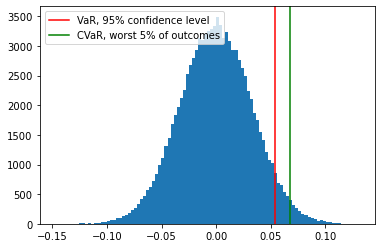

In [5]:
# Compute the mean and variance of the portfolio returns
pm = portfolio_losses.mean()
ps = portfolio_losses.std()

# Compute the 95% VaR using the .ppf()
VaR_95 = norm.ppf(0.95, loc = pm, scale = ps)
# Compute the expected tail loss and the CVaR in the worst 5% of cases
tail_loss = norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_95)
CVaR_95 = (1 / (1 - 0.95)) * tail_loss

# Plot the normal distribution histogram and add lines for the VaR and CVaR
plt.hist(norm.rvs(size = 100000, loc = pm, scale = ps), bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR, 95% confidence level")
plt.axvline(x = CVaR_95, c='g', label = "CVaR, worst 5% of outcomes")
plt.legend(); plt.show()

The CVaR is a richer measure of risk than the VaR, but can be more difficult to compute when the distribution of losses (or returns) is unknown, or is more complicated than a Normal distribution. Nevertheless, both measures are used in risk management to identify 'danger signs' when portfolio losses approach the VaR or CVaR threshold.

## VaR and risk exposure

Previously we computed the VaR and CVaR when losses were Normally distributed. Here we'll find the VaR using another common loss distribution, the Student's t-distribution (or T) contained in scipy.stats.

We'll compute an array of 99% VaR measures from the T distribution (with 30 - 1 = 29 degrees of freedom), using 30-day rolling windows from investment bank portfolio losses.

First we'll find the mean and standard deviation of each window, creating a list of rolling_parameters. We'll use these to compute the 99% VaR array of measures.

Then we'll use this array to plot the risk exposure for a portfolio initially worth $100,000. Recall that risk exposure is the probability of loss (this is 1%) multiplied by the loss amount (this is the loss given by the 99% VaR).

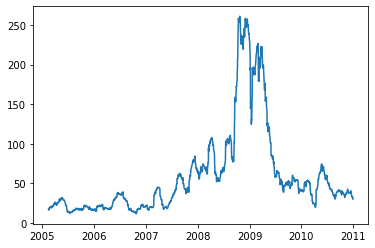

In [6]:
# Import the Student's t-distribution
from scipy.stats import t

# Create rolling window parameter list
mu = portfolio_losses.rolling(30).mean()
sigma = portfolio_losses.rolling(30).std()
rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ t.ppf(0.99, *params) 
                    for params in rolling_parameters ] )

# Plot the minimum risk exposure over the 2005-2010 time period
plt.plot(portfolio_losses.index, 0.01 * VaR_99 * 100000)
plt.show()

Outstanding! Because the confidence level was fixed at 99%, we kept the probability of loss at 1%. This means the risk exposure is just a rescaled VaR measure of the maximum portfolio loss 99% of the time. We can see how much larger the risk exposure was during the heart of the crisis in 2009.

## CVaR and risk exposure

Recall that CVaR is the expected value of loss given a minimum loss threshold. So CVaR is already in the form of a risk exposure--it is the sum (or integral) of the probability of loss in the distribution tail multiplied, by the loss amount.

In [7]:
# Fit the Student's t distribution to crisis losses
crisis_losses = portfolio_losses.loc['2008-01-01':'2009-12-31']

# Fit the Student's t distribution to crisis losses
p = t.fit(crisis_losses)

# Compute the VaR_99 for the fitted distribution
VaR_99 = t.ppf(0.99, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)

0.3380538488604617


The Student's t-distribution is widely used when the Normal distribution is too restrictive for portfolio losses, but still allows convergence to the Normal when the sample size becomes very large.

## VaR from a fitted distribution

Minimizing CVaR requires calculating the VaR at a confidence level, say 95%. Previously we derived the VaR as a quantile from a Normal (or Gaussian) distribution, but minimizing the CVaR more generally requires computing the quantile from a distribution that best fits the data.

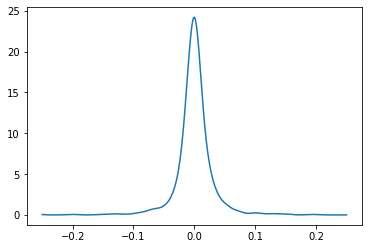

0.04287354115146831


In [8]:
from scipy import stats

# Generate a Gaussian kernal density estimate over losses
kde = stats.gaussian_kde(portfolio_losses)

# Visualize the fitted distribution with a plot
x = np.linspace(-0.25,0.25,1000)
plt.plot(x,kde.evaluate(x))
plt.show()

# Create a random sample of 100,000 observations from the fitted distribution
sample = kde.resample(100000)

# Compute and display the 95% VaR from the random sample
VaR_95 = np.quantile(sample, 0.95)
print(VaR_95)

Resampling from a fitted distribution is a common technique to build statistics such as quantiles, which are needed for VaR risk measurement. Although we derived the VaR explicitly here.

## Minimizing CVaR

In [9]:
# Import the EfficientFrontier class
from pypfopt.efficient_frontier import EfficientFrontier

# Import the negative_cvar objective function
from pypfopt.objective_functions import negative_cvar

# Import the CovarianceShrinkage object
from pypfopt.risk_models import CovarianceShrinkage

# Create the CovarianceShrinkage instance variable
cs = CovarianceShrinkage(portfolio)

# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()

# Create the efficient frontier instance
ef = EfficientFrontier(None, e_cov)

# Portfolio returns
returns = portfolio.pct_change()

# Find the cVar-minimizing portfolio weights at the default 95% confidence level
optimal_weights = ef.custom_objective(negative_cvar, returns)

# Display the optimal weights
print(optimal_weights)

{'Citibank': 0.24989380328904456, 'Morgan Stanley': 0.24975682343604122, 'Goldman Sachs': 0.24975682343604122, 'J.P. Morgan': 0.25072952969187634}


The CVaR minimizing portfolio over the 2005-2010 period is essentially equally-weighted between the four investment banks. In what follows we'll see if this conclusion continues to hold for the periods before, during and after the crisis.

## CVaR risk management and the crisis

In [10]:
import pandas as pd
from pypfopt import cla
from pypfopt.expected_returns import mean_historical_return

epochs = { 'before' : {'start': '1-1-2005', 'end': '31-12-2006'},
           'during' : {'start': '1-1-2007', 'end': '31-12-2008'},
           'after'  : {'start': '1-1-2009', 'end': '31-12-2010'}
         }

# Compute the efficient covariance for each epoch

returns_dict, expected_returns, e_cov_dict, min_vol_dict = {}, {}, {}, {}

for x in epochs.keys():
    sub_price = portfolio.loc[epochs[x]['start']:epochs[x]['end']]
    
    returns_dict[x] = sub_price.pct_change()
    e_cov_dict[x] = CovarianceShrinkage(sub_price).ledoit_wolf()
    expected_returns[x] = mean_historical_return(sub_price, frequency = 252)
    
    test1 = pd.DataFrame.from_dict(expected_returns[x])
    test2 = pd.DataFrame.from_dict(e_cov_dict[x])
    # Initialize the Crtical Line Algorithm object
    efficient_portfolio_during = cla.CLA(test1, test2)
    #efficient_portfolio_during = cla(expected_returns[x], e_cov[x])

    # Find the minimum volatility portfolio weights and display them
    min_vol_dict[x] = efficient_portfolio_during.min_volatility()

In [11]:
# Initialize the efficient portfolio dictionary
ef_dict = {}

# For each epoch, assign an efficient frontier instance to ef
for x in ['before', 'during', 'after']: 
    ef_dict[x] = EfficientFrontier(None, e_cov_dict[x])

In [12]:
# Initialize the dictionary of optimal weights
optimal_weights_dict = {}

# Find and display the CVaR-minimizing portfolio weights at the default 95% confidence level
for x in ['before', 'during', 'after']:
    optimal_weights_dict[x] = ef_dict[x].custom_objective(negative_cvar, returns_dict[x])

# Compare the CVaR-minimizing weights to the minimum volatility weights
print("CVaR:\n", pd.DataFrame.from_dict(optimal_weights_dict), "\n")
print("Min Vol:\n", pd.DataFrame.from_dict(min_vol_dict), "\n")

CVaR:
                   before  during     after
Citibank        0.251699    0.25  0.249600
Morgan Stanley  0.249296    0.25  0.250778
Goldman Sachs   0.248967    0.25  0.249542
J.P. Morgan     0.250038    0.25  0.250080 

Min Vol:
      before   during     after
0  0.657653  0.00000  0.000000
1  0.048006  0.00000  0.034383
2  0.040377  0.51799  0.862959
3  0.253963  0.48201  0.102658 



## Black-Scholes options pricing

Options are the world's most widely used derivative to help manage asset price risk. In this exercise we'll price a European call option on IBM's stock using the Black-Scholes option pricing formula. 

In [28]:
import numpy as np
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
from sympy import init_printing
init_printing()

from black_scholes import black_scholes
from black_scholes import bs_delta

def black_scholes(S, X, T, r, sigma, option_type = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / X) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option_type == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - X * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option_type == 'put':
        result = (X * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [27]:
start = datetime(2004,12,31)
end = datetime(2010,12,31)

ibm_returns = DataReader('IBM', 'yahoo',start, end)['Close'].pct_change()

# Compute the volatility as the annualized standard deviation of IBM returns
sigma = np.sqrt(252) * ibm_returns.std()

# Compute the Black-Scholes option price for this volatility
value_s = black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, sigma = sigma, option_type = "call")

# Compute the Black-Scholes option price for twice the volatility
value_2s = black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, sigma = 2*sigma, option_type = "call")

# Display and compare both values
print("Option value for sigma: ", value_s, "\n",
      "Option value for 2 * sigma: ", value_2s)

Option value for sigma:  12.588943317218806 
 Option value for 2 * sigma:  17.409221717700525


As shown, the value of the call option increases with an increase in volatility! This is because an option only needs to be exercised when it is profitable to do so, which means that more volatility increases the chance for profit.

## Options pricing and the underlying asset

Options are essentially bets on the future evolution of the underlying asset's price.

For example, a put option is valuable when the spot (market) price falls below the option's strike price. The option holder may exercise the option to sell the underlying at the strike X, and buy it back at the spot S<X, yielding profit X−S.

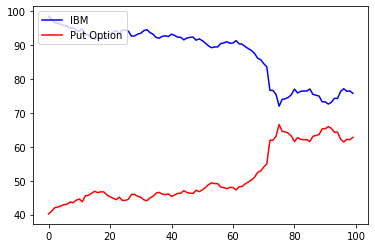

In [29]:
ibm = DataReader('IBM', 'yahoo',start, end)['Close'].reset_index().drop(columns='Date')
ibm_spot = ibm[:100]

# Initialize the European put option values array
option_values = np.zeros(ibm_spot.size)

# Iterate through IBM's spot price and compute the option values
for i,S in enumerate(ibm_spot.values):
    option_values[i] = black_scholes(S = S, X = 140, T = 0.5, r = 0.02, 
                        sigma = sigma, option_type = "put")

# Display the option values array
plt.plot(ibm_spot, color = 'blue', label = 'IBM')
plt.plot(option_values, color = "red", label = "Put Option")
plt.legend(loc = "upper left")
plt.show()

As we can see, the value of the option rises whenever the price of IBM falls (and vice-versa). This shows that an option is a good candidate for hedging changes in IBM's stock price.

## Using options for hedging

Suppose that we have an investment portfolio with one asset, IBM. We'll hedge the portfolio's risk using delta hedging with a European put option on IBM.

First, value the European put option using the Black-Scholes option pricing formula, with a strike X of 80 and a time to maturity T of 1/2 a year. The risk-free interest rate is 2% and the spot S is initially 70.

Then create a delta hedge by computing the delta of the option with the bs_delta() function, and use it to hedge against a change in the stock price to 69.5. The result is a delta neutral portfolio of both the option and the stock.

In [30]:
# Compute the annualized standard deviation of `IBM` returns
sigma = np.sqrt(252) * ibm_returns.std()

# Compute the Black-Scholes value at IBM spot price 70
value = black_scholes(S = 70, X = 80, T = 0.5, r = 0.02, 
                      sigma = sigma, option_type = "put")
# Find the delta of the option at IBM spot price 70
delta = bs_delta(S = 70, X = 80, T = 0.5, r = 0.02, 
                 sigma = sigma, option_type = "put")

# Find the option value change when the price of IBM falls to 69.5
value_change = black_scholes(S = 69.5, X = 80, T = 0.5, r = 0.02, 
                             sigma = sigma, option_type = "put") - value

print( (69.5 - 70) + (1/delta) * value_change ) # The closer to 0, the better

0.004589679366013066


The price change in IBM has been offset using the option delta. We've hedged risk the way institutional risk managers do it, which is how pension funds keep their value. Important stuff!